In [ ]:
import os
from glob import glob

import numpy as np
import torch
import torchvision
from pycocotools.coco import COCO

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class M18KDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.annotations = COCO(os.path.join(root, "_annotations.coco.json"))

    def __getitem__(self, idx):
        # load images and masks
        image_object = self.annotations.imgs[idx]
        img_path = image_object["file_name"]
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(os.path.join(self.root,img_path))
        masks = self.annotations.loadAnns(self.annotations.getAnnIds([image_object["id"]]))
        
        num_objs = len(masks)

        # tensor of shape [#objects,h,w] of binary masks
        binary_masks = torch.tensor(np.dstack([annotations.annToMask(mask) for mask in masks]),dtype=torch.uint8).permute([2,0,1])
        
        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(binary_masks)

        # there is only one class
        labels = torch.tensor([mask["category_id"] for mask in masks],dtype=torch.int64)

        image_id = idx
        area = torch.tensor([mask["area"] for mask in masks],dtype=torch.float32)
        # suppose all instances are not crowd
        iscrowd = torch.tensor([mask["iscrowd"] for mask in masks],dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(binary_masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            print(type(target))
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.annotations.imgs)

ds = M18KDataset("M18K/Dataset/train",None)
ds[0]

In [ ]:
annotations = COCO(os.path.join("M18K/Dataset/train", "_annotations.coco.json"))

In [ ]:
img = read_image(os.path.join("M18K/Dataset/train",annotations.imgs[0]["file_name"]))
img


In [ ]:
import numpy as np
masks = annotations.loadAnns(annotations.getAnnIds([annotations.imgs[0]["id"]]))
binary_masks = torch.tensor(np.dstack([annotations.annToMask(mask) for mask in masks]),dtype=torch.uint8).permute([2,0,1])
binary_masks.shape

In [ ]:
from M18K.Data.Dataset import M18KDataset
from M18K.Data.DataModule import M18KDataModule
from M18K.Models.TorchVision import MaskRCNN_ResNet50
from lightning import LightningModule, Trainer
from torchvision import transforms
from lightning.pytorch import loggers as pl_loggers
import argparse
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [ ]:
from M18K.Data.Dataset import M18KDataset
from M18K.Data.DataModule import M18KDataModule
from M18K.Models.TorchVision import MaskRCNN_ResNet50
from lightning import LightningModule, Trainer
from torchvision import transforms
from lightning.pytorch import loggers as pl_loggers
import argparse
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

def main(model_name="resnet_18"):
    # Instantiate the data module
    t = transforms.ToTensor()
    # if model_name == "swin_v2_b":
    #     t = transforms.Compose([transforms.ToTensor(),transforms.Grayscale()])
    dm = M18KDataModule(batch_size=2)

    # Instantiate the model
    model = MaskRCNN_ResNet50()

    checkpoint_callback = ModelCheckpoint(
        save_top_k=100,
        monitor="val_loss",
        mode="min",
        dirpath=f"runs/{model_name}/",
        filename= model_name+"-{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}",
    )

    #early_stop_callback = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=50, verbose=False, mode="max")

    # Initialize a trainer
    tb_logger = pl_loggers.TensorBoardLogger(save_dir=f"runs/{model_name}/")
    trainer = Trainer(max_epochs=100,devices=1,log_every_n_steps=1,logger=tb_logger,callbacks=[checkpoint_callback])

    # Train the model ⚡
    trainer.fit(model, dm)


if __name__ == '__main__':
    # parser = argparse.ArgumentParser(description='A simple script with command-line arguments.')
    # parser.add_argument('model', type=str, help='model name')
    # args = parser.parse_args()
    # model = args.model
    main()

In [ ]:
import torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

In [121]:
import os
import cv2

import numpy as np
import torch
import torchvision.transforms
from pycocotools.coco import COCO

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F



class M18KDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, train=True):
        self.root = root
        self.transforms = transforms
        self.annotations = COCO(os.path.join(root, "_annotations.coco.json"))
        self.train = True
    
    def augmentation(self, image, masks):
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomScale(0.1),
            A.Affine([0.8,1.2],[0.8,1.2],None,[-360, 360],[-45, 45],fit_output=True,p=1),
            A.Resize(720,1280)
        ])
    
        transformed = transform(image=image, masks=masks)
        transformed_image = transformed['image']
        transformed_mask = transformed['masks']
        
        return transformed_image,transformed_mask
    
    def __getitem__(self, idx):
        # load images and masks
        image_object = self.annotations.imgs[idx]
        img_path = image_object["file_name"]
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = cv2.imread(os.path.join(self.root, img_path))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        masks = self.annotations.loadAnns(self.annotations.getAnnIds([image_object["id"]]))
        
        mask_list = [self.annotations.annToMask(mask) for mask in masks]
        
        img, mask_list = self.augmentation(img,mask_list)
        
        # tensor of shape [#objects,h,w] of binary masks
        binary_masks = torch.tensor(np.dstack(mask_list), dtype=torch.uint8).permute([2, 0, 1])
        
        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(binary_masks)
        
        # there is only one class
        labels = torch.tensor([mask["category_id"] for mask in masks], dtype=torch.int64)

        image_id = idx
        area = torch.tensor([mask["area"] for mask in masks], dtype=torch.float32)

        iscrowd = torch.tensor([mask["iscrowd"] for mask in masks], dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        #img = tv_tensors.Image(img)
        img = torchvision.transforms.ToTensor()(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(binary_masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None and self.train:
            img, target = self.transforms(img, target)
        return (img, target,mask_list)
    def __len__(self):
        return len(self.annotations.imgs)
    
ds = M18KDataset(root="M18K/Data/train",transforms=None)


loading annotations into memory...
Done (t=1.01s)
creating index...
index created!


/var/folders/zs/_qj4bk415ln1zhpb2dx9tqpm0000gn/T/ipykernel_46287/2987422706.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', n_masks)


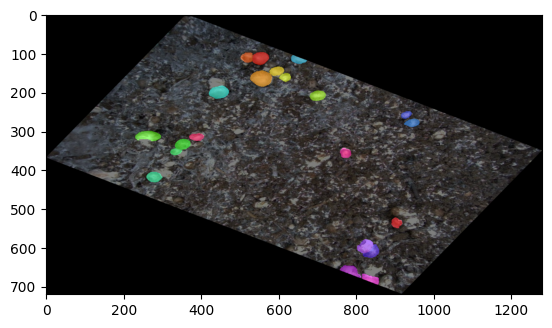

In [135]:
import matplotlib.pyplot as plt
image,_,masks = ds[0]
img = image.permute(1,2,0).numpy()
plt.imshow(overlay_masks(img,masks))


In [119]:
def overlay_masks(image, masks, alpha=0.5):
    """Overlay multiple binary masks on an image."""
    # Create a color map - each mask will have a unique color
    n_masks = len(masks)
    colors = plt.cm.get_cmap('hsv', n_masks)

    # Create a colored image to overlay
    colored_overlay = np.zeros_like(image)

    for i, mask in enumerate(masks):
        color = colors(i)[:3]  # Get RGB color
        colored_mask = np.zeros_like(image)
        for j in range(3):  # Apply color to the mask
            colored_mask[:, :, j] = color[j]
        colored_overlay[mask == 1] = colored_mask[mask == 1]

    # Overlay the colored image on the original image
    return cv2.addWeighted(image, 1 - alpha, colored_overlay, alpha, 0)


/var/folders/zs/_qj4bk415ln1zhpb2dx9tqpm0000gn/T/ipykernel_46287/2987422706.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', n_masks)


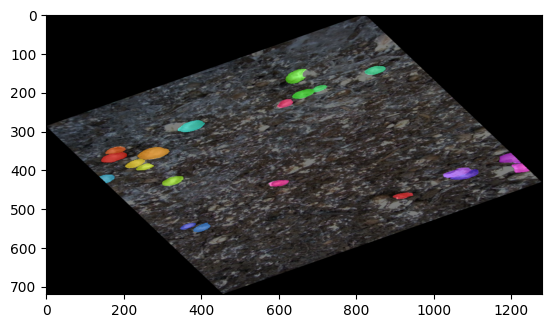

In [ ]:
boxes

In [ ]:
import albumentations as A

In [ ]:
images,targets = batch

In [ ]:
images

In [ ]:
model(images,targets)